In [3]:
# !pip install --upgrade https://github.com/EmilWine/gpuRIR/zipball/master

     / 3.2MB 517kB/s
  Created wheel for gpuRIR: filename=gpuRIR-1.2.0-cp36-cp36m-linux_x86_64.whl size=907266 sha256=9dee55cc6f0a0e85af83d53764df470772b57c3af59bda65da3ff45917894680
  Stored in directory: /tmp/pip-ephem-wheel-cache-53a7gkns/wheels/44/78/8c/467ec8c9afc4a3193a9427dbd7ca6609857b4add99d1aa9829
Successfully built gpuRIR


In [38]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from math import ceil
import librosa
import librosa.display
import gpuRIR
import scipy.signal as signal


%matplotlib nbagg

In [40]:
room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 1  # Number of sources
pos_src = np.array([[1,0,0.5]]) # Positions of the sources ([m]
nb_rcv = 2 # Number of receivers
pos_rcv = np.array([[0.5,1,0.5],[0.6,1,0.5]])	 # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) # Vectors pointing in the same direction than the receivers
mic_pattern = "omni" # Receiver polar pattern
abs_weights = [1.0]*5+[1.0] # Absortion coefficient ratios of the walls
T60 = 1.0 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
Tw = 3 #samples window 
fs=48000 # Sampling frequency [Hz]



In [41]:
beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension


In [42]:
# beta = np.array([0.0]*5 + [1.0])

In [43]:
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, Tw, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

<IPython.core.display.Javascript object>


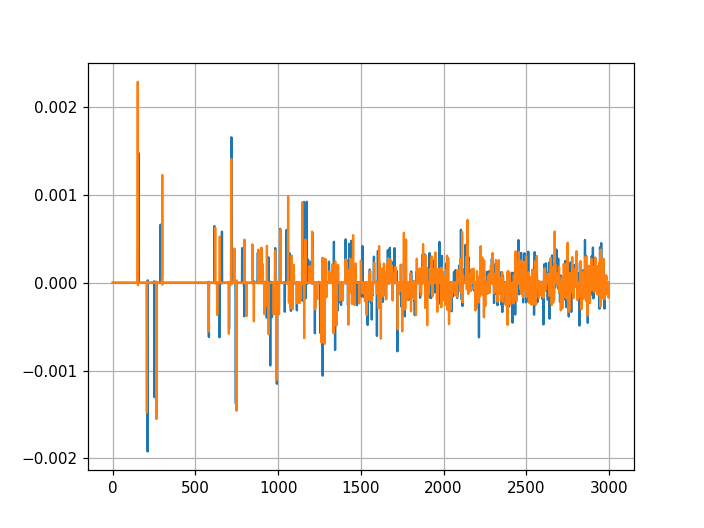

In [44]:
t = np.arange(int(ceil(Tmax * fs))) / fs
plt.figure()
plt.plot(RIRs[0,:,:3000].T)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


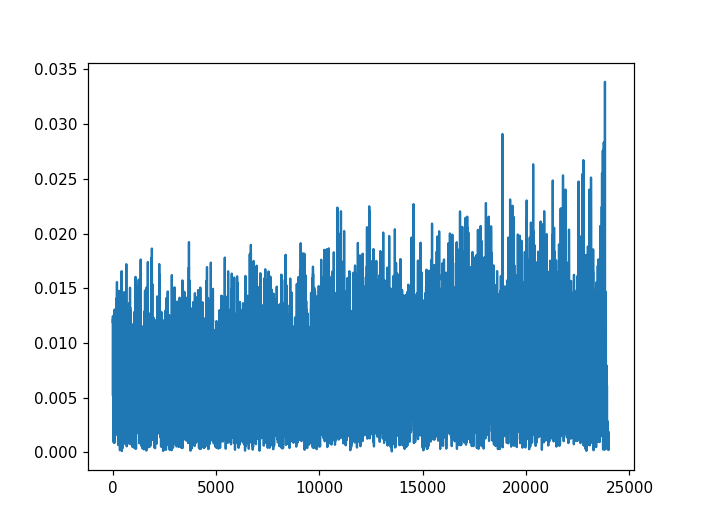

In [45]:
sig = RIRs[0,0,:]
ft_sig = np.fft.fftshift(np.fft.fft(sig))
plt.figure()
plt.plot(np.abs(ft_sig[:(fs>>1)]))
plt.show()

In [8]:
Nfft = int(4e-3 * fs)
Nhop = Nfft >>2
print(Nfft,Nhop)


192 48


/home/emilw/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


<IPython.core.display.Javascript object>


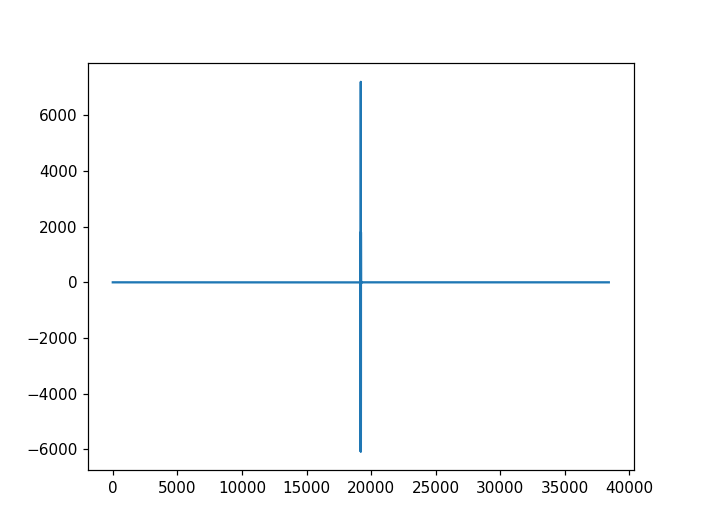

<IPython.core.display.Javascript object>


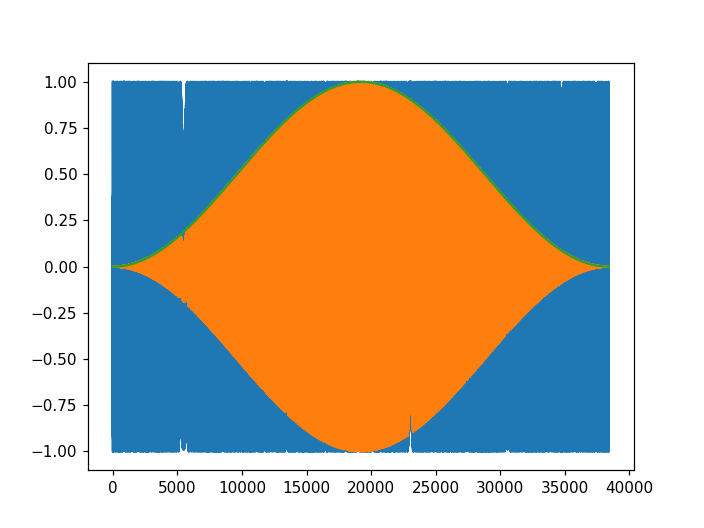

<IPython.core.display.Javascript object>


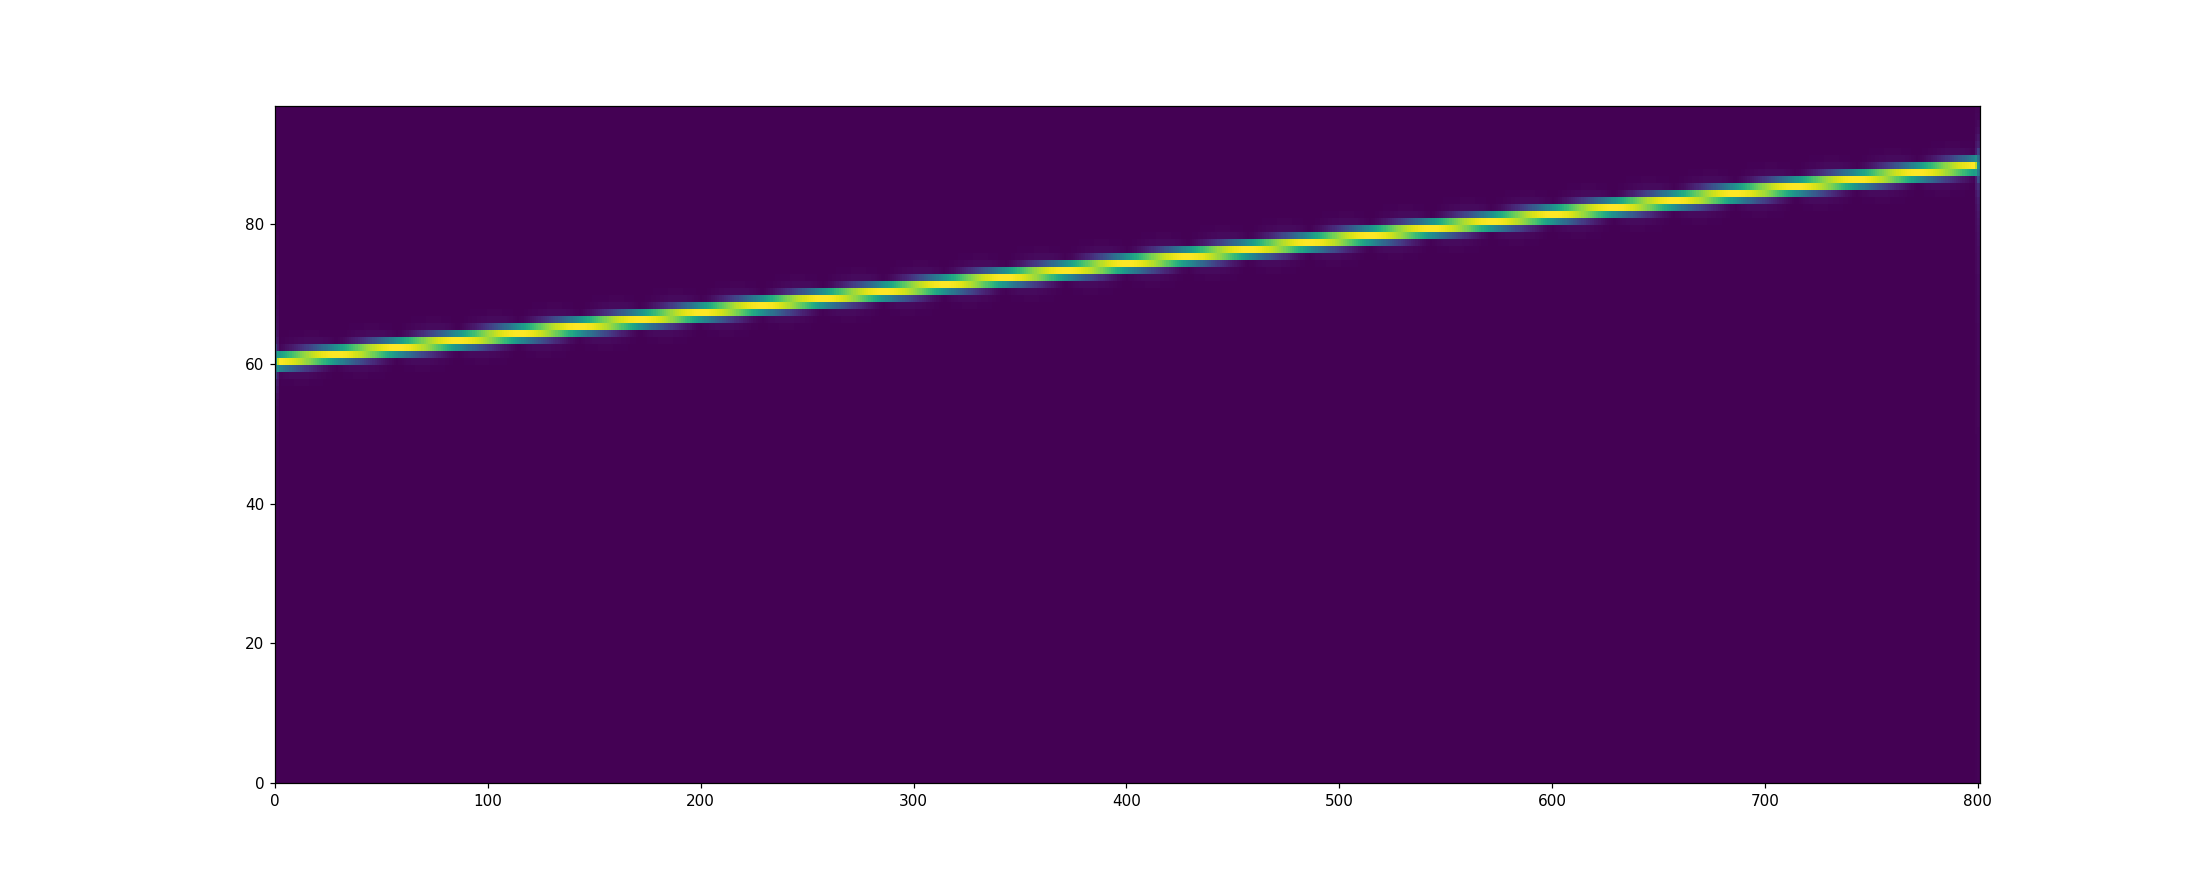

In [37]:
## Logchirp
t_probe = 0.8
t = np.arange(int(ceil(t_probe * fs))) / fs

probe_sig = signal.chirp(t,15000,t_probe,22000,method="linear")
window = signal.hanning(len(probe_sig))
probe_windowed = window*probe_sig

probe_corr = signal.correlate(probe_windowed,probe_windowed,'same')

plt.figure()
plt.plot(probe_corr)
plt.show()


plt.figure()
plt.plot(probe_sig)
plt.plot(probe_windowed)
plt.plot(window)
plt.show()
_,_,probe_stft = signal.stft(probe_sig,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=True)

plt.figure(figsize=(20,8))
plt.pcolormesh(np.abs(probe_stft))
plt.show()





In [10]:
f,t,ft_r1 = signal.stft(RIRs[0,0,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
_,_,ft_r2 = signal.stft(RIRs[0,1,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
cc = ft_r1 * ft_r2.conj() / (1e-6 + np.abs(ft_r1)*np.abs(ft_r2))
print(cc.shape)

(192, 1001)


[]

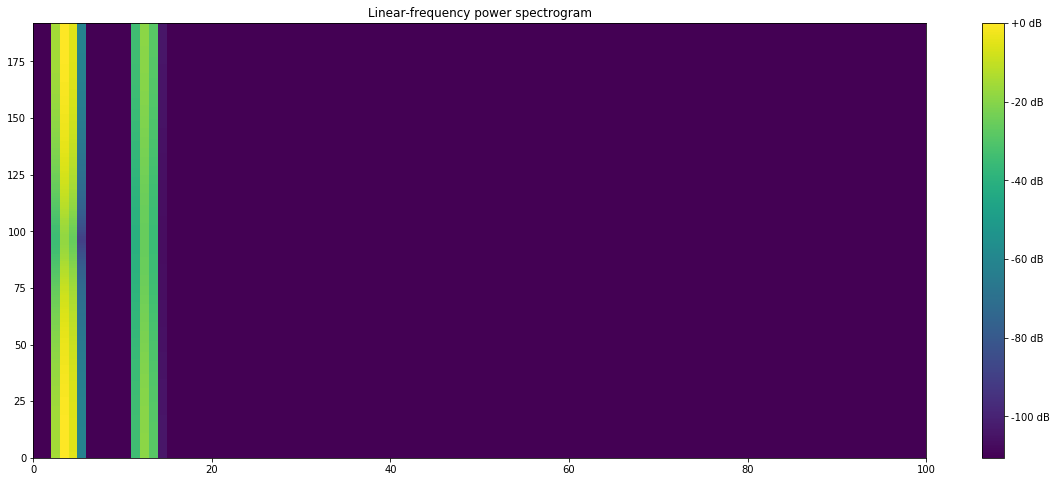

In [11]:
D = 20*np.log10(np.abs(cc) + 1e-6)
D -= np.max(D)
D = D[:,:100]

plt.figure(figsize=(20,8))
plt.pcolormesh(D)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.plot()

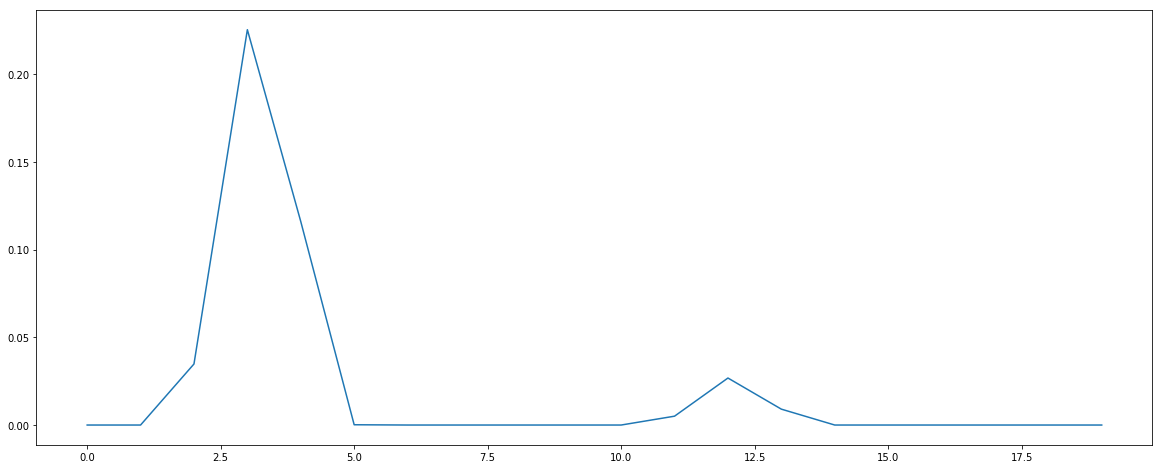

In [12]:
plt.figure(figsize=(20,8))
plt.plot(np.abs(cc[50,:20]))
plt.show()

In [13]:
## Make one sided
cc_hilb  = cc.copy()
cc_hilb[:1+(Nfft>>1),:] = 0#-1j*cc_hilb[:1+(Nfft>>1),:]

(192, 1000)


/home/emilw/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1445: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


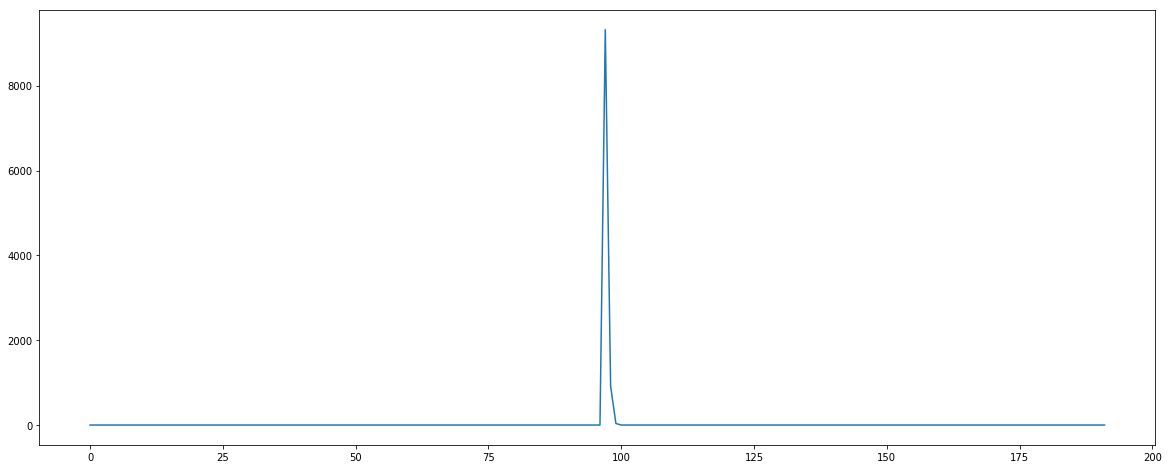

In [14]:
_,icc = signal.istft(cc,fs=fs,nperseg=Nfft,noverlap=0,input_onesided = False)

icc = icc.reshape(-1,Nfft).T
print(icc.shape)

plt.figure(figsize=(20,8))
plt.plot(np.abs(icc[:,11]))
# plt.plot(np.real(icc[:,3]))
# plt.plot(np.imag(icc[:,3]))
plt.show()




# plt.figure(figsize=(20,8))
# plt.plot(icc[:,:20])

# plt.show()

In [15]:
icc.sh

AttributeError: 'numpy.ndarray' object has no attribute 'sh'